https://medium.com/towards-data-science/twitter-sentiment-analysis-on-car-brands-c13d449eb9fc
https://www.ravikiranj.net/posts/2012/code/how-build-twitter-sentiment-analyzer/
http://textblob.readthedocs.io/en/latest/advanced_usage.html#sentiment-analyzers
https://marcobonzanini.com/2015/05/17/mining-twitter-data-with-python-part-6-sentiment-analysis-basics/
http://www.geeksforgeeks.org/twitter-sentiment-analysis-using-python/
https://dev.to/rodolfoferro/sentiment-analysis-on-trumpss-tweets-using-python-

http://adataanalyst.com/scikit-learn/countvectorizer-sklearn-example/

# Proyecto 1

Temas Selectos de Tecnologías del lenguaje

Semestre 2018-1

Olivares Castillo José Luis


# Descripción
Este trabajo es una tarea de aprendizaje supervisado que consiste en la clasificación de tweets en:
* Positivos
* Negativos


# Método de aprendizaje
El método de aprendizaje utilizado es el algoritmo de [Naive Bayes](http://scikit-learn.org/stable/modules/naive_bayes.html) que está incluido en la biblioteca de Machine Learning [Scikit-learn](http://scikit-learn.org/stable/), en específico una variación de este algoritmo que se llama [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB) que se utiliza generalmente para clasificación de texto.

Se elige este método ya que es escalable y computacionalmente no es muy complejo durante la etapa de entrenamiento.



# Dependecias
* [scikit-learn](http://scikit-learn.org/stable/)
* [Numpy](http://www.numpy.org/)
* [Pandas](https://pandas.pydata.org/)
* [NLTK](http://www.nltk.org/)
* [stop_words](https://pypi.python.org/pypi/stop-words)
* [snowballstemmer](https://pypi.python.org/pypi/snowballstemmer)
* [matplotlib](https://matplotlib.org/)


In [1]:
# -*- coding: utf-8 -*-
"""
    @author: jose 
    FI UNAM
    Created on Thu Oct  26 21:22:06 2017
"""

from sklearn import naive_bayes as NB
from nltk.tokenize import TweetTokenizer
import os
import numpy as np
import pandas as pd
from stop_words import get_stop_words
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import snowballstemmer
import matplotlib.pyplot as plt
%matplotlib inline

# Datasets
Los datasets usados son tweets etiquetados de la siguiente manera:
* 1 para tweets positivos.
* 2 para tweets negativos.



In [2]:
home = os.getcwd()
os.chdir(home + '/data')
os.getcwd()
pos_tweets = pd.read_csv('true_posi.txt', sep="\t", names=["Etiqueta","Tweet"])
neg_tweets = pd.read_csv('true_negs.txt', sep="\t", names=["Etiqueta","Tweet"])
os.chdir(home)

In [3]:
pos_tweets.head()

,Etiqueta,Tweet
0,1,@_FerTf grosera jaja muy amable usted igual de...
1,1,@KarenkaaPanqee wooow!!! ^^!! No me muero sin ...
2,1,@akhs190lo hago para gustarte mas mi amor! :) ...
3,1,"@miriworld Si, por favor (:"
4,1,Hay porfin en mi casita (:


In [4]:
neg_tweets.head()

,Etiqueta,Tweet
0,2,Prohibido subir un gramo de aquí a diciembre :(
1,2,BUENO SIGO DEPRIMIDA SIN MI CELULAR Y MI NEXTE...
2,2,@miguelgali11 mikeeeee!! como q estas enfermoo...
3,2,RT @mariowanna83: Esos Reyes no me trajeron mi...
4,2,Perdon es lo unico que puedo pedirte :( Patric...


# Tamaño de datasets

In [5]:
print("# de tweets con etiqueta positiva:",pos_tweets.__len__())

# de tweets con etiqueta positiva: 5496


In [6]:
print("# de tweets con etiqueta negativa:",neg_tweets.__len__())

# de tweets con etiqueta negativa: 6670


# Tamaño total de tweets

In [7]:
tweets = pd.concat([pos_tweets,neg_tweets])
print("# total de tweets:",tweets.__len__())

# total de tweets: 12166


# Descripción del dataset
La biblioteca [Pandas](https://pandas.pydata.org/) permite hacer un análisis del dataset, en este caso se agrupan todos los tweets por sus etiquetas y se obtiene lo siguiente:

In [8]:
tweets.groupby('Etiqueta').describe()

Tweet
Etiqueta                         
1        count               5496
         unique              5481
         top          Buen dia :)
         freq                   3
2        count               6670
         unique              6642
         top     Me siento mal :(
         freq                   5

De la tabla anterior podemos observar el total de tweets tanto positivos como negativos, así como los que están repetidos que están en el renglón `top` y la frecuencia con la que se repitieron

# Preprocesamiento del dataset

Para preprocesar los tweets antes de iniciar la etapa de entrenamiento, se realiza lo siguiente:

* Tokenización: La biblioteca de [NLTK](http://www.nltk.org/) tiene una clase dedicada para tokenizar tweets, donde se puede convertir cada token a minúsculas, se eliminan caracteres repetidos i.e. (hooooooola -> hola) y se pueden eliminar los usuarios que estén mencionados dentro del tweet. También permite reconocer emoticonos como :) :( :D :S :* etc.

* Stemming: El stemming se aplica a los tokens para reducir las palabras a su raíz y así evitar tener variaciones de una misma palabra que pudieran afectar el desempeño del algoritmo.

* Listas de paro: Se utilizan listas de paro para eliminar de los tweets signos de puntuación y palabras funciones que no aportan información relevante al contenido de los tweets.

In [9]:
tknzr = TweetTokenizer(preserve_case=False,       # Convertir a minúsculas
                       reduce_len=True,           # Reducir caracteres repetidos
                       strip_handles=False)        # Mostrar @usuarios

stemmer = snowballstemmer.stemmer('Spanish')

lista_de_paro = ['"',"“","/","(",")","[","]","?","¿","!","¡",
                 "rt",":","…",",","\n","#","@","\t","",".","$",
                 "...","-","🤢","newLineCharacter","|","%","<","=",
                 ">","+"]

es_stop = get_stop_words('es')

# `Limpiar` tweets 

In [10]:
def clean_tweet(tweet):
    """
    Eliminar tokens que:
    - Estén dentro de lista_de_paro.
    - Sean ligas.
    - Si es una mención i.e @potus, se cambia por token genérico @usuario.
    """
    return [stemmer.stemWord(_) if not _.startswith(("@")) else '' for _ in tweet 
            if _ not in lista_de_paro
            and not _.startswith(('http', 'htt'))
            and _ not in es_stop]           

In [11]:
clean_tuit = []
for tuit in tweets["Tweet"]:
    clean_tokens = clean_tweet(tknzr.tokenize(tuit))
    clean_tuit.append(' '.join(clean_tokens))

In [12]:
tweets["Tweet"] = clean_tuit

# Tweet preprocesados

In [13]:
tweets.groupby('Etiqueta').describe()

Tweet
Etiqueta                
1        count      5496
         unique     5380
         top      hol :)
         freq         16
2        count      6670
         unique     6531
         top          :(
         freq         28

De la tabla anterior se observa que una vez preprocesados los tweets, los que tienen etiqueta 1 (positiva) se caracterizan por tener "hol :)" y los tweets negativos se caracterizan por tener un emoticon 'triste' :(

# Tamaño tweets

Se añade una columna donde se almacena la longitud de los tweets, esto con el fin de averiguar si la longitud del tweet tiene alguna relación con la clase a la que pertenece.

In [14]:
tweets['length'] = tweets['Tweet'].apply(len)

In [15]:
tweets.head()

,Etiqueta,Tweet,length
0,1,groser jaj amabl usted igual descans mañan mu...,64
1,1,wooow ^ ^ muer ir contig :),28
2,1,hag gustart mas amor :) jiji,29
3,1,si favor (:,12
4,1,porfin casit (:,15


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe1d58b5c50>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fe1d5695978>], dtype=object)

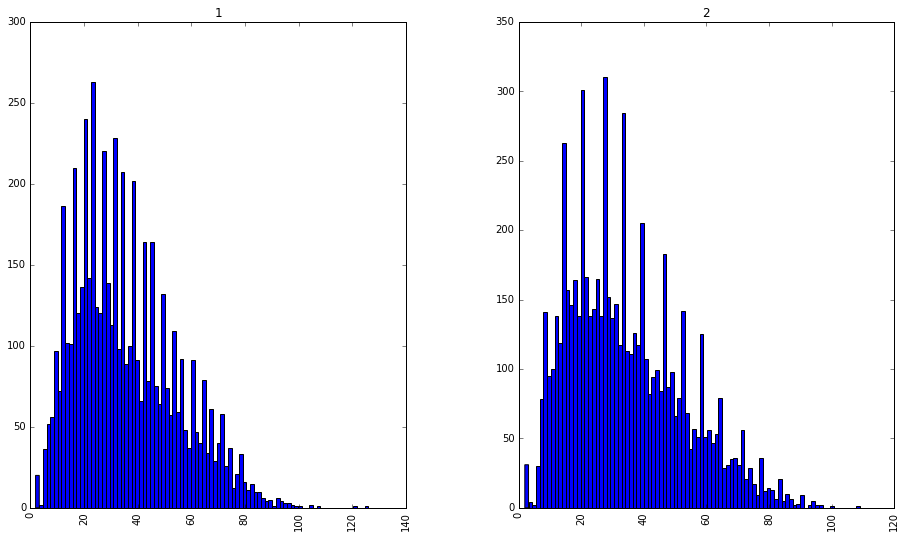

In [16]:
tweets.hist(column='length',by ='Etiqueta',bins=90,figsize = (15,9))

De estas gráficas se observa que los tweets positivos y positivos tienen una distribución similar, sin embargo, hay más tweets negativos dentro del rango de 15-50 que tweets negativos.

# Representación vectorial
Para la representación vectorial de los tweets se utiliza la clase `TfidfVectorizer` que está incluida en la biblioteca de [Scikit-learn](http://scikit-learn.org/stable/). Esta clase crea una matriz TF-IDF de cada tweet. 

In [17]:
vectorizer = TfidfVectorizer(use_idf=True,
                             lowercase=True,
                             strip_accents='ascii',
                             #stop_words=stopset,
                             smooth_idf=True
                                )

# Evaluación 
Se separa el dataset en subconjuntos de entretamiento y prueba, para esto se utiliza la clase [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). los datos se dividen en 75% para el conjunto de entrenamiento y 25% para el conjunto de pruebas

In [18]:
X = vectorizer.fit_transform(tweets["Tweet"])
y = tweets["Etiqueta"]

La representación vectorial de los tweets es una matriz de:

In [19]:
print(X.shape)

(12166, 10675)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [21]:
# Clasificador Naive Bayes

In [22]:
clf = NB.MultinomialNB(alpha=0.42,fit_prior=True)
clf.fit(X_train,y_train)

MultinomialNB(alpha=0.42, class_prior=None, fit_prior=True)

In [23]:
clf.score(X_test,y_test)

0.77744904667981596

In [24]:
new_tweet = np.array(["Ojalá mañana sea un buen día"])

new_tweet_vector = vectorizer.transform(new_tweet)
print(new_tweet_vector)
print(clf.predict(new_tweet_vector)[0])

  (0, 10001)	0.546318232435
  (0, 7031)	0.546318232435
  (0, 6056)	0.546318232435
  (0, 3085)	0.240335983063
  (0, 1563)	0.216443484476
1


In [25]:
from sklearn.metrics import classification_report,confusion_matrix

In [26]:
all_predictions = clf.predict(vectorizer.transform(tweets["Tweet"]))

In [27]:
print (all_predictions)

[1 1 1 ..., 2 2 2]


In [28]:
print (classification_report(tweets['Etiqueta'], all_predictions))

             precision    recall  f1-score   support

          1       0.90      0.82      0.86      5496
          2       0.86      0.93      0.89      6670

avg / total       0.88      0.88      0.88     12166



In [29]:
print(confusion_matrix(tweets['Etiqueta'],all_predictions))

[[4489 1007]
 [ 479 6191]]
